In [1]:
#Colab setting
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/DSAIL')

import os
os.chdir('/content/drive/My Drive/DSAIL')

Mounted at /content/drive


In [2]:
#!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [2]:
# Data U1.base로 train, u1.test로 test data만들기
# U.data는 현재 (["user_id", "movie_id", "rating", "timestamp"])로 구성
import pandas as pd
import torch

file_path = "ml-100k/u1.base"
columns = ["user_id", "movie_id", "rating", "timestamp"]
train_data = pd.read_csv(file_path, sep='\t', names=columns)
user_movie_matrix = train_data.pivot(index='user_id', columns='movie_id', values='rating')
train = user_movie_matrix.fillna(0)

file_path = "ml-100k/u1.test"
columns = ["user_id", "movie_id", "rating", "timestamp"]
test_data = pd.read_csv(file_path, sep='\t', names=columns)
user_movie_matrix = test_data.pivot(index='user_id', columns='movie_id', values='rating')
test = user_movie_matrix.fillna(0)

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device", device)

device cuda


In [5]:
print(train.head)

<bound method NDFrame.head of movie_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                               ...   
1          5.0   3.0   4.0   3.0   3.0   0.0   4.0   1.0   5.0   0.0  ...   
2          4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  ...   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...        ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
939        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   5.0   0.0  ...   
940        0.0   0.0   0.0   2.0   0.0   0.0   4.0   5.0   3.0   0.0  ...   
941        5.0   0.0   0.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0  ...   
942        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
943        0.0   5.0   0.0   0.0   0.0   0.0  

In [35]:
# PMF
# N: # of users
# M: # of movies
# D: dimension

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

def g(x):
    return 1 / (1+torch.exp(-x))

class PMF(nn.Module):
  def __init__(self, train_R, test_R, d=30, lambdaV=0.001, lambdaU=0.01 ,learning_rate=1e-3, epochs=30, constrain = False, device=device):
    '''
    constrain: True -> constrained pmf
    I: rating 있으면 1 없으면 0
    '''
    super(PMF, self).__init__()
    self.n, self.m = train_R.shape
    self.device = device
    train_R_values = train_R.to_numpy()
    self.k = float(np.max(train_R_values))

    self.latent_dimension = d
    self.U = nn.Parameter(0.1 * torch.rand(self.latent_dimension, self.n).to(self.device)) # random initialize (D, N)
    self.V = nn.Parameter(0.1 * torch.rand(self.latent_dimension, self.m).to(self.device)) # (D, M)
    self.constrain = constrain

    if self.constrain:
      self.W = nn.Parameter(torch.rand(self.latent_dimension, self.m)).to(self.device) # (D, M)

    self.lambdaV = lambdaV
    self.lambdaU = lambdaU

    self.train_R = train_R
    self.scaled_train_R = (self.train_R - 1) / (self.k - 1)
    self.scaled_train_R = torch.tensor(self.scaled_train_R.to_numpy(), dtype=torch.float32).to(self.device)
    self.test_R = test_R
    self.scaled_test_R = torch.tensor((self.test_R.to_numpy() - 1) / (self.k - 1), dtype=torch.float32).to(self.device)
    self.lr = learning_rate
    self.epoch = epochs
    self.I = torch.tensor((train_R > 0).values, dtype=torch.float32).to(self.device) # (N, M)

    self.optimizer = optim.Adam(self.parameters(), lr=self.lr)
    self.criterion = nn.MSELoss()
    print("Number of User:", self.n)
    print("Number of Movies:", self.m)
    print("Hidden dimension:", self.latent_dimension)
    print("Max Rating:", self.k)

  def loss(self):
    if self.constrain:
      # I (N, M) 애랑 W (D, M) # U (D, N)
      #uv = self.U # u= v+ (IW) / I
      row_sums = torch.sum(self.I.t(), dim=0)
      result = torch.matmul(self.W, self.I.t()) / row_sums# (D, N)
      uv = self.U + result.to(device)
      uv = uv.to(device)
      # for i in range(self.n):
      #   uv[i, :] = uv[i, :] + torch.matmul(self.I[i, :], self.W.t()) / torch.sum(self.I[i, :])
      predicted_R = self.I * torch.matmul(uv.transpose(0, 1), self.V)
      loss = 0.5 * self.criterion(g(predicted_R), self.scaled_train_R) + self.lambdaV / 2 * torch.sum(self.U**2)
    else:
      predicted_R = self.I * torch.matmul(self.U.transpose(0, 1), self.V)
      loss = 0.5 * self.criterion(predicted_R, self.scaled_train_R) + self.lambdaU / 2 * torch.sum(self.U**2) + self.lambdaV / 2 * torch.sum(self.V**2)
    return loss

  def fit(self):
    train_loss_list = []
    for epoch in range(self.epoch):
      self.train()
      loss = self.loss()
      train_loss_list.append(loss)
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      if epoch % 20 == 0:
        print(f'Epoch [{epoch}/{self.epoch}], Loss: {loss.item()}')
    return self.U, self.V, train_loss_list


Number of User: 943
Number of Movies: 1650
Hidden dimension: 30
Max Rating: 5.0
Epoch [0/100], Loss: 0.5973430871963501
Epoch [20/100], Loss: 0.3316344618797302
Epoch [40/100], Loss: 0.18044278025627136
Epoch [60/100], Loss: 0.10347006469964981
Epoch [80/100], Loss: 0.06731902807950974


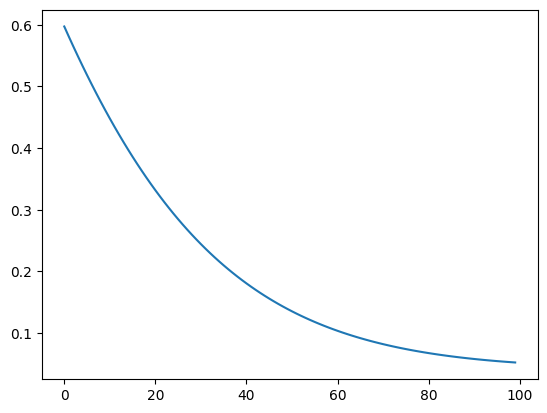

In [36]:
import matplotlib.pyplot as plt

model = PMF(train_R = train, test_R = test, epochs= 100, constrain=False)

# Train the model
u1, v1, train_loss_list1 = model.fit()
train_loss_tensor = torch.tensor(train_loss_list1, dtype=torch.float32)
plt.plot(train_loss_tensor.cpu().numpy())


Number of User: 943
Number of Movies: 1650
Hidden dimension: 30
Max Rating: 5.0
Epoch [0/100], Loss: 0.3154676556587219
Epoch [20/100], Loss: 0.2928299307823181
Epoch [40/100], Loss: 0.2800328731536865
Epoch [60/100], Loss: 0.2735491394996643
Epoch [80/100], Loss: 0.27051669359207153


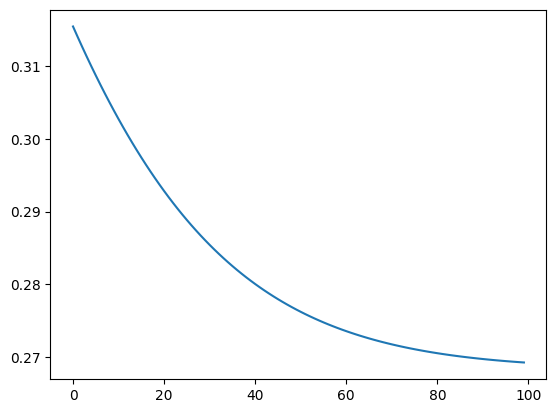

In [38]:
model = PMF(train_R = train, test_R = test,  epochs= 100, constrain=True)

# Train the model
u2, v2, train_loss_list2 = model.fit()
train_loss_tensor = torch.tensor(train_loss_list2, dtype=torch.float32)
plt.plot(train_loss_tensor.cpu().numpy())